In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}
data = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["train"])
df_val = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["validation"])
df_test = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["test"])

2025-11-08 04:21:11.933232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762575672.123361      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762575672.178562      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
# data = pd.read_csv('/kaggle/input/olp-ai-ptit/train.csv')
tokenizer = Tokenizer(oov_token='<OOV>')
max_len = 100

In [4]:
data
lb = {
    0:'negative',
    1:'neutral',
    2:'positive'
}

In [5]:
X, y = data['text'].values, data['label'].values

In [24]:
tokenizer.fit_on_texts(X)
tokenizer_json = tokenizer.to_json()

with open("../models/tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer_json)

In [7]:
seq = tokenizer.texts_to_sequences(X)

In [8]:
valx, valy = df_val['text'], df_val['label']
valx_seq = tokenizer.texts_to_sequences(valx)
# valx_seq
maxlen = max_len
valx_padd = pad_sequences(valx_seq, truncating='post', maxlen=maxlen, padding='post')

In [9]:
# maxlen = 50
vocab_size = len(tokenizer.word_index)
embed_size = 100

In [10]:
padding = pad_sequences(seq, truncating='post', maxlen=maxlen, padding='post')

In [11]:
vocab_size

29766

In [12]:
print(padding[:2])

[[2677 8640 5778 1286    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 124 1063   12 2347  750   65    3  181   37   14    4  162    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [13]:
class PositionEncode(Layer):
    def __init__(self, max_len, vocab_size, embed_size):
        super().__init__()
        self.embed = Embedding(input_dim=vocab_size, output_dim=embed_size, mask_zero=True)
        self.pos_embed = Embedding(
            input_dim=max_len, output_dim=embed_size
        )
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.max_len = max_len
    def call(self, inputs):
        len = tf.shape(inputs)[-1]
        pos_range = tf.range(start=0, limit=len, delta=1)
        embeded = self.embed(inputs)
        pos_embeded = self.pos_embed(pos_range)
        return embeded + pos_embeded
class EncodeBlock(Layer):
    def __init__(self, ff_size, embed_size, num_heads):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_size)
        self.ffw = tf.keras.Sequential([
            Dense(ff_size, activation='relu'),
            Dense(embed_size)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
    def call(self, inputs):
        atted = self.att(inputs, inputs)
        n1 = self.norm1(atted + inputs)
        ffwed = self.ffw(n1)
        return self.norm2(ffwed + n1)
max_len = maxlen
num_heads = 1
vocab_size=vocab_size
ff_size= 128
num_class = 3
model = tf.keras.Sequential([
    # PositionEncode(max_len=max_len, vocab_size=vocab_size, embed_size=embed_size),
    Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_len, mask_zero=False),
    # EncodeBlock(num_heads=num_heads, embed_size=embed_size, ff_size=ff_size),
    # Dropout(0.2),
    # GlobalAveragePooling1D(),
    Bidirectional(LSTM(128, return_sequences=False)),
    # Bidirectional(LSTM(128, return_sequences=False)),
    Dense(32, activation='relu'),
    Dense(num_class, activation='softmax')
    
])
model.build((None, embed_size))
model.summary()
from tensorflow.keras.optimizers import *
model.compile(optimizer=AdamW(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(padding, y, epochs=7, batch_size=128, validation_data=(valx_padd, valy))
        
        

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1762575688.141744      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     2,976,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,219,419 (12.28 MB)

 Trainable params: 3,219,419 (12.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7


I0000 00:00:1762575693.742484      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.3805 - loss: 1.0905 - val_accuracy: 0.5016 - val_loss: 1.0189
Epoch 2/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5292 - loss: 0.9445 - val_accuracy: 0.5958 - val_loss: 0.8496
Epoch 3/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6394 - loss: 0.7760 - val_accuracy: 0.6363 - val_loss: 0.7890
Epoch 4/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7034 - loss: 0.6890 - val_accuracy: 0.6636 - val_loss: 0.7642
Epoch 5/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7540 - loss: 0.6192 - val_accuracy: 0.6699 - val_loss: 0.7578
Epoch 6/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7812 - loss: 0.5591 - val_accuracy: 0.6755 - val_loss: 0.7658
Epoch 7/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8038 - loss: 0.5100 - val_accuracy: 0.6734 - val_loss: 0.7788


In [14]:
model.save('btlpython2.h5')

In [15]:
df_val = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["validation"])

In [16]:


testx, testy = df_val['text'], df_val['label']
testx_seq = tokenizer.texts_to_sequences(valx)
# valx_seq
testx_padd = pad_sequences(testx_seq, truncating='post', maxlen=maxlen, padding='post')


In [17]:

predict = np.argmax(model.predict(testx_padd), axis=1)
from sklearn.metrics import classification_report

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [18]:
print(classification_report(testy, predict))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1517
           1       0.60      0.61      0.61      1928
           2       0.77      0.72      0.74      1760

    accuracy                           0.67      5205
   macro avg       0.68      0.68      0.68      5205
weighted avg       0.68      0.67      0.67      5205



In [19]:
test_ = ['so love, but i like this']
testt = tokenizer.texts_to_sequences(test_)
print(testt)
testt_padd = pad_sequences(testt, truncating='post', maxlen=max_len, padding='post')
print(testt_padd)
prdd = np.argmax(model.predict(testt_padd), axis=1)
prdd

[[22, 44, 15, 2, 32, 17]]
[[22 44 15  2 32 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([2])

In [20]:
lb[int(prdd)]

/tmp/ipykernel_39/977579642.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lb[int(prdd)]


'positive'

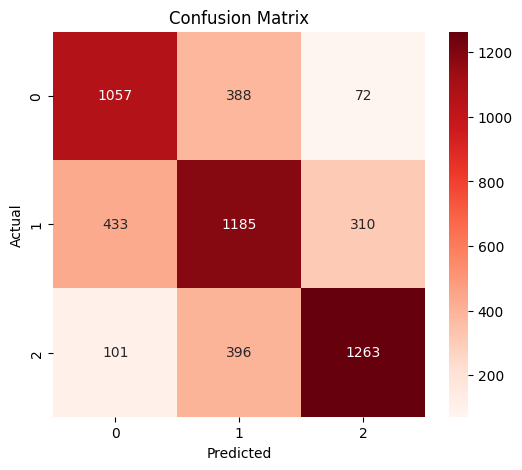

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testy, predict)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


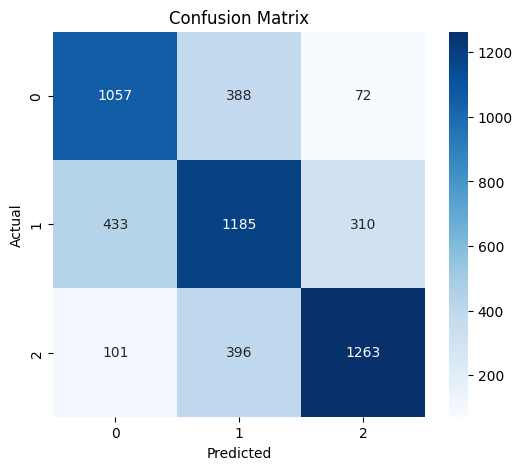

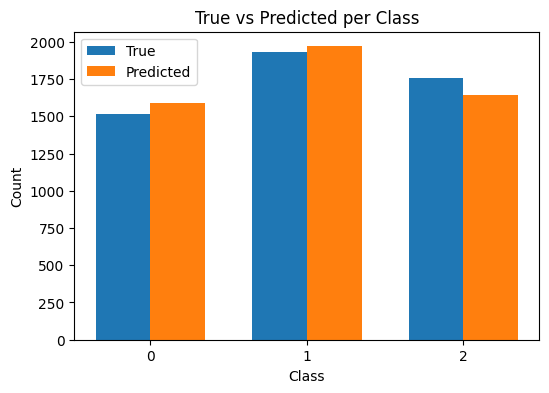

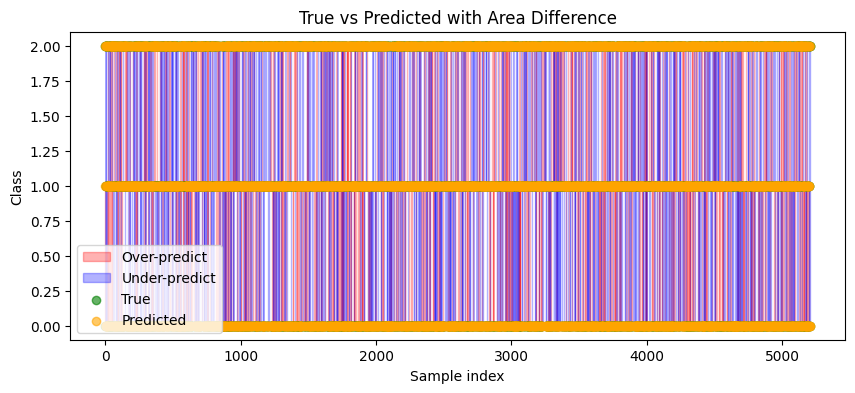

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_true = testy    
y_pred = predict   

classes = np.unique(y_true)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

counts_true = [sum(y_true==i) for i in classes]
counts_pred = [sum(y_pred==i) for i in classes]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, counts_true, width, label='True')
plt.bar(x + width/2, counts_pred, width, label='Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('True vs Predicted per Class')
plt.xticks(x, classes)
plt.legend()
plt.show()


plt.figure(figsize=(10,4))


diff = y_pred - y_true
plt.fill_between(range(len(y_true)), y_true, y_pred, 
                 where=(y_pred>y_true), color='red', alpha=0.3, label='Over-predict')
plt.fill_between(range(len(y_true)), y_true, y_pred, 
                 where=(y_pred<y_true), color='blue', alpha=0.3, label='Under-predict')

# Scatter nhãn thật và dự đoán
plt.scatter(range(len(y_true)), y_true, label='True', color='green', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='orange', alpha=0.6)

plt.xlabel('Sample index')
plt.ylabel('Class')
plt.title('True vs Predicted with Area Difference')
plt.legend()
plt.show()
